## Google Trends Crawler

Google Trends only provides coarse-grained data for long-period queries. For example, when querying trends for the keyword, COVID, during 2020/01/22-2021/03-16, Google Trends only exhibits weekly trends during the period. Thus, we need to construct fine-grained (daily) data for our model training next.

Another problem is that we cannot simply merge the daily data for extension, since different time frames for the same date may lead to different trend values. Specifically, the data point with the highest hotness in each time period will be assigned 100, other values are determined based on their relative hotness between the highest one. Consequently, we need to adjust the values to the same scale in all time periods to obtain the final dataset.


In [18]:
import time
from datetime import datetime, timedelta, date, time
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError

sns.set_style('whitegrid')
sns.set_palette('Set2')

In [59]:
def fetch_trends(trendreq, keywords, timeframe, max_retries=3):
    """ Fetch Google Trends data. Retry if the request failed
    :param trendreq: Google Trends request object
    :param keywords: trend request payloads (keywords)
    :param timeframe: time frame in request
    :param max_retries: the max number of retries
    :return: DataFrame object
    """
    attempts = 0
    fetched = False
    while not fetched:
        try:
            trendreq.build_payload(kw_list=keywords, timeframe=timeframe)
        except ResponseError as err:
            # Sleep before next fetch due to the time limit of Google servers
            attempts += 1
            if attempts > max_retries:
                print(f'Aborting!')
                break
            print(f'Trying again in {60 + 5 * attempts} seconds...')
            sleep(60 + 5 * attempts)
        else:
            fetched = True
    return trendreq.interest_over_time()

def get_daily_trend(trendreq, keyword, start_str, end_str, delta=268, overlap=100):

    """ Fetch trends data from start to end date, and then convert
      trends data in different time frames into the same scale using
      overlapping areas.
    :param trendreq: Google Trends request object
    :param keyword: keyword for retrieval
    :param start: starting date in string format (YYYY-MM-DD, e.g. 2020-01-22)
    :param end: ending date in string format (YYYY-MM-DD, e.g. 2021-03-16)
    :param delta: the number of days in each time frame
    :param overlap: the number of days of the overlapping period for scaling
    """
    
    # Converting string to time format
    start = datetime.strptime(start_str, '%Y-%m-%d')
    end = datetime.strptime(end_str, '%Y-%m-%d')
    init_end = datetime.strptime(end_str, '%Y-%m-%d')
    init_end.replace(hour=23, minute=59, second=59)
    delta = timedelta(days=delta)
    overlap = timedelta(days=overlap)
    # Calculate the start of the last time frame
    cur = end - delta
    overlap_start = None
    # Initialize data frames for the results and overlapping data
    df = pd.DataFrame()
    overlap_df = pd.DataFrame()
    
    while end > start:
        timeframe = cur.strftime('%Y-%m-%d') + ' ' + end.strftime('%Y-%m-%d')
        # Dataframe for duration [cur, end]
        cur_end = fetch_trends(trendreq, [keyword], timeframe)
        cur_end.drop(columns=['isPartial'], inplace=True)
        cur_end.columns.values[0] = timeframe
        # Overlapping dataframe for duration [cur, end]
        overlap_cur_end = cur_end.copy()
        overlap_cur_end.iloc[:,:] = None
        # Exclude the first iteration
        if overlap_start is not None:
            # Scaling using the maximum value of the overlapped period, [overlap_start, end]
            max_cur_end = cur_end.loc[overlap_start:end].iloc[:,0].values.max()
            max_df = df.loc[overlap_start:end].iloc[:,-1].values.max()
            # Multiplying the scaling coefficient
            cur_end = cur_end * (max_df / max_cur_end)
            overlap_cur_end.loc[overlap_start:end, :] = 1 
        # Concatenate the results in this iteration with the rest
        df = pd.concat([df,cur_end], axis=1)
        overlap_df = pd.concat([overlap_df, overlap_cur_end], axis=1)
        # Shifting
        overlap_start = cur
        end -= (delta - overlap)
        cur -= (delta - overlap)
        # Google Trends servers may ban the IP if the queries are too frequent
        # time.sleep(1)
    
    # Order in time
    df.sort_index(inplace=True)
    overlap_df.sort_index(inplace=True)
    # Complete the recent 3-days data with hourly trends
    if df.index.max() < init_end:
        timeframe = 'now 7-d'
        hourly = fetch_trends(trendreq, [keyword], timeframe)
        hourly.drop(columns=['isPartial'], inplace=True)
        # Using groupby operations to aggregate to daily data
        daily = hourly.groupby(hourly.index.date).sum()
        daily['hours'] = hourly.groupby(hourly.index.date).count()
        # If the data for the first day is not complete (24 hours)
        if daily.iloc[0].loc['hours'] != 24:
           daily.drop(daily.index[0], inplace=True)
        daily.drop(columns='hours', inplace=True)
        
        daily.set_index(pd.DatetimeIndex(daily.index), inplace=True)
        daily.columns = [timeframe]
        
        overlap_cur_end = daily.copy()
        overlap_cur_end.iloc[:,:] = None
        # i.e. overlapping dates
        intersect = df.index.intersection(daily.index)
        # Scaling with today-4 to today-7 data
        coef = df.loc[intersect].iloc[:,0].max() / daily.loc[intersect].iloc[:,0].max()
        daily = (daily*coef).round(decimals=0)
        overlap_cur_end.loc[intersect,:] = 1
        # Concatenate the results
        df = pd.concat([daily, df], axis=1)
        overlap_df = pd.concat([overlap_cur_end, verlap_df], axis=1)

    # Calculating averages of overlapped period
    df = df.mean(axis=1)
    overlap_df = overlap_df.max(axis=1)
    df = pd.DataFrame({keyword: df})
    df = df[start:init_end]
    # Normalized to range [0, 100]
    df[keyword] = (100 * df[keyword] / df[keyword].max()).round(decimals=0)
    
    return df


In [50]:
trend = TrendReq()
covid_df = get_daily_trend(trend, 'COVID', '2020-01-22', '2021-03-16')
vaccine_df = get_daily_trend(trend, 'vaccine', '2021-01-22', '2021-03-16')
df = pd.concat([covid_df, vaccine_df], axis=0)
df.to_csv('trends_data.csv')

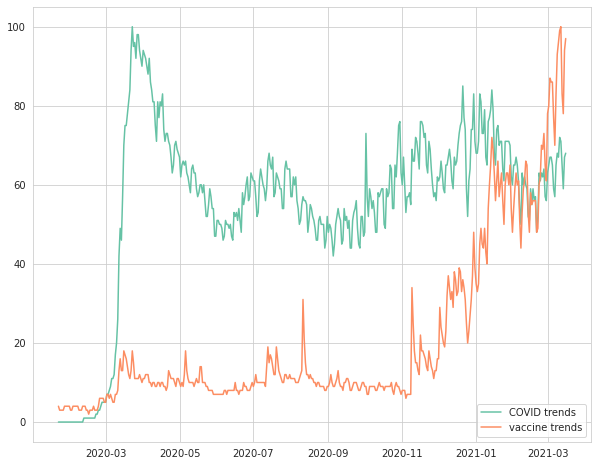

In [63]:
plt.figure(figsize=(10, 8))
plt.title('')
plt.plot(df['COVID'], label='COVID trends')
plt.plot(df['vaccine'], label='vaccine trends')
plt.legend()
plt.show()